In [34]:
# ============================================================
# IDRiD MULTI-LESION SEGMENTATION (APPLE M-SERIES SAFE)
# ============================================================

import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import imageio.v2 as imageio
from tqdm import tqdm

# ============================
# CONFIG
# ============================
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
IMG_SIZE = 512
ROOT = "/Users/akhilgattu/Desktop/VLM_project"
OUT_DIR = "./visual_results"
os.makedirs(OUT_DIR, exist_ok=True)

LESIONS = [
    "Microaneurysms",
    "Haemorrhages",
    "HardExudates",
    "SoftExudates",
    "OpticDisc"
]

COLORS = {
    "Microaneurysms": (255, 0, 0),
    "Haemorrhages": (0, 0, 255),
    "HardExudates": (255, 255, 0),
    "SoftExudates": (0, 255, 255),
    "OpticDisc": (0, 255, 0)
}

THRESHOLDS = {
    "Microaneurysms": 0.2,
    "Haemorrhages": 0.3,
    "HardExudates": 0.4,
    "SoftExudates": 0.4,
    "OpticDisc": 0.5
}

LESION_FOLDERS = {
    "Microaneurysms": "1. Microaneurysms",
    "Haemorrhages": "2. Haemorrhages",
    "HardExudates": "3. Hard Exudates",
    "SoftExudates": "4. Soft Exudates",
    "OpticDisc": "5. Optic Disc"
}

SUFFIX_MAP = {
    "Microaneurysms": "_MA.tif",
    "Haemorrhages": "_HE.tif",
    "HardExudates": "_EX.tif",
    "SoftExudates": "_SE.tif",
    "OpticDisc": "_OD.tif"
}

# ============================
# DATASET
# ============================
class IDRiDSegmentationDataset(Dataset):
    def __init__(self, root, split="train"):
        if split == "train":
            self.image_dir = os.path.join(root, "A. Segmentation", "1. Original Images", "a. Training Set")
            self.mask_root = os.path.join(root, "A. Segmentation", "2. All Segmentation Groundtruths", "a. Training Set")
        else:
            self.image_dir = os.path.join(root, "A. Segmentation", "1. Original Images", "b. Testing Set")
            self.mask_root = os.path.join(root, "A. Segmentation", "2. All Segmentation Groundtruths", "b. Testing Set")

        self.images = sorted(os.listdir(self.image_dir))

    def __len__(self):
        return len(self.images)

    def _load_mask(self, path):
        if not os.path.exists(path):
            return np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        m = imageio.imread(path)

        # 🔑 FIX: convert bool → uint8
        if m.dtype == np.bool_:
            m = m.astype(np.uint8) * 255

        m = cv2.resize(m, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        return (m > 0).astype(np.float32)


    def __getitem__(self, idx):
        name = self.images[idx]
        base = name.replace(".jpg", "")

        img = cv2.imread(os.path.join(self.image_dir, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        img_t = torch.tensor(img).permute(2, 0, 1).float()

        masks = []
        for lesion in LESIONS:
            path = os.path.join(
                self.mask_root,
                LESION_FOLDERS[lesion],
                base + SUFFIX_MAP[lesion]
            )
            masks.append(self._load_mask(path))

        masks = torch.tensor(np.stack(masks)).float()
        return img_t, masks, img, name

# ============================
# MODEL (UNET)
# ============================
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)

        self.dec3 = DoubleConv(512, 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)
        self.out = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(e4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out(d1)

# ============================
# LOSS
# ============================
def dice_loss_multilabel(logits, targets):
    probs = torch.sigmoid(logits)
    loss, valid = 0.0, 0

    for c in range(probs.shape[1]):
        t = targets[:, c]
        if t.sum() == 0:
            continue
        p = probs[:, c]
        intersection = (p * t).sum()
        union = p.sum() + t.sum() + 1e-6
        loss += 1 - (2 * intersection / union)
        valid += 1

    return loss / max(valid, 1)

# ============================
# METRICS
# ============================
def dice_scores(logits, targets):
    probs = torch.sigmoid(logits)
    results = {}

    for i, lesion in enumerate(LESIONS):
        t = targets[:, i]
        if t.sum() == 0:
            continue
        p = (probs[:, i] > THRESHOLDS[lesion]).float()
        dice = (2 * (p * t).sum()) / (p.sum() + t.sum() + 1e-6)
        results[lesion] = dice.item()

    return results

def foreground_accuracy(logits, targets):
    probs = torch.sigmoid(logits)
    pred_fg = torch.zeros_like(targets[:, 0])
    gt_fg = torch.zeros_like(targets[:, 0])

    for i, lesion in enumerate(LESIONS):
        pred_fg |= (probs[:, i] > THRESHOLDS[lesion])
        gt_fg |= (targets[:, i] > 0)

    return (pred_fg == gt_fg).float().mean().item()

# ============================
# TRAINING
# ============================
def train(model, loader, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    bce = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        model.train()
        total = 0.0

        for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
            imgs, masks = batch[0].to(DEVICE), batch[1].to(DEVICE)
            optimizer.zero_grad()

            logits = model(imgs)
            loss = 0.7 * bce(logits, masks) + 0.3 * dice_loss_multilabel(logits, masks)
            loss.backward()
            optimizer.step()
            total += loss.item()

        print(f"Epoch {epoch+1} | Loss: {total/len(loader):.4f}")

# ============================
# VISUALIZATION
# ============================
def overlay(image, pred_masks):
    out = image.copy()
    for i, lesion in enumerate(LESIONS):
        mask = pred_masks[i]
        out[mask > 0] = 0.6 * out[mask > 0] + 0.4 * np.array(COLORS[lesion])
    return out.astype(np.uint8)

def visualize(model, dataset, n=5):
    model.eval()
    for i in range(n):
        img_t, masks, img_np, name = dataset[i]
        with torch.no_grad():
            logits = model(img_t.unsqueeze(0).to(DEVICE))
            probs = torch.sigmoid(logits)[0].cpu()

        pred = np.zeros_like(probs.numpy())
        for j, lesion in enumerate(LESIONS):
            pred[j] = (probs[j] > THRESHOLDS[lesion]).numpy()

        vis = overlay((img_np * 255).astype(np.uint8), pred)
        cv2.imwrite(os.path.join(OUT_DIR, name), cv2.cvtColor(vis, cv2.COLOR_RGB2BGR))

# ============================
# MAIN
# ============================
if __name__ == "__main__":
    train_ds = IDRiDSegmentationDataset(ROOT, "train")
    test_ds = IDRiDSegmentationDataset(ROOT, "test")

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
    model = UNet(n_classes=5).to(DEVICE)

    train(model, train_loader, epochs=50)
    visualize(model, test_ds)
    torch.save({"model_state_dict": model.state_dict()}, "unet_idrids.pth")

Epoch 1:   0%|          | 0/27 [00:00<?, ?it/s]/var/folders/61/80bh8zbs3rg_9w2k2zqhghd00000gn/T/ipykernel_1493/4086962817.py:88: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = m.astype(np.uint8) * 255
Epoch 1: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 1 | Loss: 0.7170


Epoch 2: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


Epoch 2 | Loss: 0.6503


Epoch 3: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


Epoch 3 | Loss: 0.6279


Epoch 4: 100%|██████████| 27/27 [00:24<00:00,  1.10it/s]


Epoch 4 | Loss: 0.6112


Epoch 5: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


Epoch 5 | Loss: 0.5949


Epoch 6: 100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Epoch 6 | Loss: 0.5783


Epoch 7: 100%|██████████| 27/27 [01:55<00:00,  4.27s/it]


Epoch 7 | Loss: 0.5649


Epoch 8: 100%|██████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 8 | Loss: 0.5493


Epoch 9: 100%|██████████| 27/27 [00:24<00:00,  1.09it/s]


Epoch 9 | Loss: 0.5358


Epoch 10: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 10 | Loss: 0.5238


Epoch 11: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 11 | Loss: 0.5107


Epoch 12: 100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


Epoch 12 | Loss: 0.4998


Epoch 13: 100%|██████████| 27/27 [00:26<00:00,  1.00it/s]


Epoch 13 | Loss: 0.4889


Epoch 14: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 14 | Loss: 0.4786


Epoch 15: 100%|██████████| 27/27 [00:27<00:00,  1.02s/it]


Epoch 15 | Loss: 0.4679


Epoch 16: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 16 | Loss: 0.4574


Epoch 17: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 17 | Loss: 0.4482


Epoch 18: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 18 | Loss: 0.4394


Epoch 19: 100%|██████████| 27/27 [00:27<00:00,  1.03s/it]


Epoch 19 | Loss: 0.4310


Epoch 20: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 20 | Loss: 0.4223


Epoch 21: 100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


Epoch 21 | Loss: 0.4147


Epoch 22: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 22 | Loss: 0.4077


Epoch 23: 100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


Epoch 23 | Loss: 0.4005


Epoch 24: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 24 | Loss: 0.3939


Epoch 25: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 25 | Loss: 0.3890


Epoch 26: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 26 | Loss: 0.3840


Epoch 27: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 27 | Loss: 0.3781


Epoch 28: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 28 | Loss: 0.3716


Epoch 29: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 29 | Loss: 0.3657


Epoch 30: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 30 | Loss: 0.3606


Epoch 31: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch 31 | Loss: 0.3555


Epoch 32: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 32 | Loss: 0.3505


Epoch 33: 100%|██████████| 27/27 [00:29<00:00,  1.09s/it]


Epoch 33 | Loss: 0.3454


Epoch 34: 100%|██████████| 27/27 [00:29<00:00,  1.08s/it]


Epoch 34 | Loss: 0.3411


Epoch 35: 100%|██████████| 27/27 [01:42<00:00,  3.80s/it]


Epoch 35 | Loss: 0.3366


Epoch 36: 100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Epoch 36 | Loss: 0.3329


Epoch 37: 100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Epoch 37 | Loss: 0.3284


Epoch 38: 100%|██████████| 27/27 [00:25<00:00,  1.07it/s]


Epoch 38 | Loss: 0.3238


Epoch 39: 100%|██████████| 27/27 [00:27<00:00,  1.01s/it]


Epoch 39 | Loss: 0.3218


Epoch 40: 100%|██████████| 27/27 [00:28<00:00,  1.07s/it]


Epoch 40 | Loss: 0.3144


Epoch 41: 100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch 41 | Loss: 0.3116


Epoch 42: 100%|██████████| 27/27 [00:31<00:00,  1.17s/it]


Epoch 42 | Loss: 0.3065


Epoch 43: 100%|██████████| 27/27 [00:32<00:00,  1.19s/it]


Epoch 43 | Loss: 0.3047


Epoch 44: 100%|██████████| 27/27 [00:30<00:00,  1.12s/it]


Epoch 44 | Loss: 0.2998


Epoch 45: 100%|██████████| 27/27 [00:30<00:00,  1.13s/it]


Epoch 45 | Loss: 0.2963


Epoch 46: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch 46 | Loss: 0.2927


Epoch 47: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch 47 | Loss: 0.2899


Epoch 48: 100%|██████████| 27/27 [00:33<00:00,  1.24s/it]


Epoch 48 | Loss: 0.2864


Epoch 49: 100%|██████████| 27/27 [00:31<00:00,  1.16s/it]


Epoch 49 | Loss: 0.2819


Epoch 50: 100%|██████████| 27/27 [00:32<00:00,  1.21s/it]


Epoch 50 | Loss: 0.2824


In [7]:
torch.save({
    "model_state_dict": model.state_dict()}, "unet_idrids.pth")

In [35]:
visualize(model, test_ds)

/var/folders/61/80bh8zbs3rg_9w2k2zqhghd00000gn/T/ipykernel_1493/4086962817.py:88: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  m = m.astype(np.uint8) * 255


In [ ]:
import torch
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    """
    pred: (B, C, H, W) – raw logits or probabilities
    target: (B, H, W) – class indices
    """
    pred = F.softmax(pred, dim=1)
    num_classes = pred.shape[1]

    target_onehot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    dims = (0, 2, 3)
    intersection = torch.sum(pred * target_onehot, dims)
    union = torch.sum(pred + target_onehot, dims)

    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()



(tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0000, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]],

        [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0

In [20]:
DEVICE = "mps" if torch.cuda.is_available() else "cpu"

model = UNet(n_classes=5).to(DEVICE)
checkpoint = torch.load("unet_idrids.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()


UNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (net): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3,

In [21]:
from torch.utils.data import DataLoader

test_dataset = IDRiDSegmentationDataset(
    root=ROOT,
    split="test"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True  # ensures a different image
)


batch = next(iter(test_loader))
image = batch[0].to(DEVICE)
mask = batch[1].to(DEVICE)
print(batch[3])


('IDRiD_75.jpg',)


In [28]:
import torch

def dice_loss_onehot(pred, target, smooth=1e-6):
    """
    pred   : (B, C, H, W) logits
    target : (B, C, H, W) one-hot mask
    """
    pred = torch.softmax(pred, dim=1)
    target = target.float()

    dims = (0, 2, 3)
    intersection = torch.sum(pred * target, dims)
    union = torch.sum(pred + target, dims)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1. - dice.mean()


In [27]:
print(mask.shape, image.shape)

torch.Size([1, 5, 512, 512]) torch.Size([1, 3, 512, 512])


In [29]:
img_id = batch[3][0]
with torch.no_grad():
    pred = model(image)
    loss = dice_loss_onehot(pred, mask.long())

print(f"Test Image ID: {img_id}")
print(f"Dice Loss: {loss.item():.4f}")

Test Image ID: IDRiD_75.jpg
Dice Loss: 0.9477


In [31]:
def per_class_dice(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)
    target = target.float()

    dices = []
    for c in range(pred.shape[1]):
        p = pred[:, c]
        t = target[:, c]
        intersection = (p * t).sum()
        union = p.sum() + t.sum()
        dice = (2 * intersection + smooth) / (union + smooth)
        dices.append(dice.item())

    return dices

scores = per_class_dice(pred, mask)

for i, d in enumerate(scores):
    print(f"Class {i} Dice: {d:.4f}")


Class 0 Dice: 0.0038
Class 1 Dice: 0.0407
Class 2 Dice: 0.0081
Class 3 Dice: 0.0051
Class 4 Dice: 0.2036


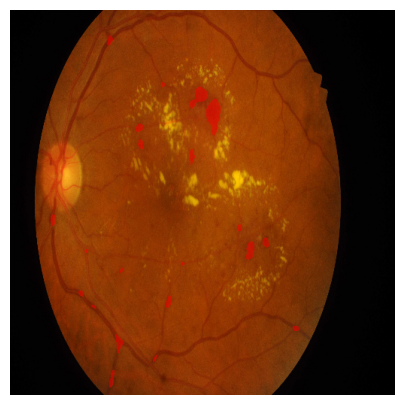

In [40]:
lesion = "Haemorrhages"
i = LESIONS.index(lesion)

overlay_mask(
    img,
    gt[i].numpy(),
    (pred[i] > 0.5).numpy()
)
